In [1]:
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
from seaborn import distplot

from openpyxl import load_workbook

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering

from sklearn.metrics import silhouette_score

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn import svm

import collections
import matplotlib.pyplot as plt 
import operator

import gensim
import re
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import WordPunctTokenizer
import pymorphy2
m = pymorphy2.MorphAnalyzer()
sw = stopwords.words('russian')
badwords = []

In [2]:
z = zipfile.ZipFile('zip.zip', 'r') 
z.printdir()

File Name                                             Modified             Size
raiffeisen_ru_google_msk.xlsx                  2019-10-23 03:16:30        77889
raiffeisen_ru_google_spb.xlsx                  2019-10-23 03:17:42        76184
raiffeisen_ru_yandex_msk.xlsx                  2019-10-23 03:15:54        78594
raiffeisen_ru_yandex_spb.xlsx                  2019-10-23 03:17:12        76183


### xlsx to df

In [4]:
google_msk_lw = load_workbook(z.extract('google_msk.xlsx'))
google_spb_lw = load_workbook(z.extract('google_spb.xlsx'))
yandex_msk_lw = load_workbook(z.extract('yandex_msk.xlsx'))
yandex_spd_lw = load_workbook(z.extract('yandex_spb.xlsx'))

In [5]:
g_msk = google_msk_lw.get_sheet_by_name('Sheet1')
g_spd = google_spb_lw.get_sheet_by_name('Sheet1')
ya_msk = yandex_msk_lw.get_sheet_by_name('Sheet1')
ya_spd = yandex_spd_lw.get_sheet_by_name('Sheet1')


C:\Ana\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  """Entry point for launching an IPython kernel.
C:\Ana\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  
C:\Ana\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Ana\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  after removing the cwd from sys.path.


In [5]:
def make_ok_df(sheet):
    headline = pd.DataFrame(sheet.values)
    df = pd.DataFrame(sheet.values, columns = headline[:1].get_values()[0])[1:]
    index_ok = [i for i in range(len(df))]
    df = df.set_index([pd.Index(index_ok)])
    del headline
    return df

In [6]:
google_msk_df = make_ok_df(g_msk)
google_spb_df = make_ok_df(g_spd)
yandex_msk_df = make_ok_df(ya_msk)
yandex_spb_df = make_ok_df(ya_spd)


In [7]:
# google_spb_df == yandex_spb_df ---> значения метрик и прочее должно быть одинаковое!
(google_spb_df['AdCopy'] == yandex_spb_df['AdCopy']).astype(int).sum()

1000

### Make str int/float

In [8]:
def str_to_int(df, name_col):
    for i in range(len(df)):
        #df[name_col][i].lstrip()
        #df[name_col][i].rstrip()
        if df[name_col][i].find(' '):
            df[name_col][i] = int(df[name_col][i].replace(' ', ''))
    #ckeck is all str int now? --> yes, if nothing printed        
    for i in range(len(df)):
        if type(df[name_col][i]) != int:
            print(i)

In [9]:
def str_to_float(df, name_col):
    for i in range(len(df)):
        #df[name_col][i].lstrip()
        #df[name_col][i].rstrip()
        try:
            if df[name_col][i].find(','):
                df[name_col][i] = float(df[name_col][i].replace(',', '.'))
        except:    
            if df[name_col][i] == None:
                df[name_col][i] = float(0)
            elif type(df[name_col][i][1]) == str:
                df[name_col][i] = df[name_col][i][-1]
        finally:
            df[name_col][i] = float(df[name_col][i])
                
    #ckeck is all str float now? --> yes, if nothing printed                   
    for i in range(len(df)):
        if type(df[name_col][i]) != float:
            print(i)

In [10]:
def str_to_int_float_extented(df):
    str_to_int(df, 'Volume')
    str_to_float(df, 'CPC')
    str_to_float(df, 'TraffShare %')
    extended = df[['Volume', 'CPC', 'TraffShare %', 'KeyComp']]
    return extended

In [11]:
google_msk_extended = str_to_int_float_extented(google_msk_df)
google_spb_extended = str_to_int_float_extented(google_spb_df)
yandex_msk_extended = str_to_int_float_extented(yandex_msk_df)
yandex_spb_extended = str_to_int_float_extented(yandex_spb_df)

### Analyses

In [12]:
def cleanText(data):
    data = data.apply(lambda x: str(x))
    pattern = re.compile(r'[_\d]|[^\w]',re.U)
    texts = [WordPunctTokenizer().tokenize(document) for document in data]
    texts = [[re.sub(pattern,'',word).lower() for word in text] for text in texts]
    texts = [[m.parse(word)[0].normal_form for word in text if len(word)>=3 and word not in badwords\
              and word not in sw] for text in texts]
    return texts

In [13]:
def Make_Clean_Sentenses(df):
    ad = pd.Series(df['AdCopy'])
    ad_clean = cleanText(pd.Series(ad))
    sentences = [' '.join(i) for i in ad_clean]
    return sentences

In [14]:
def count_vect_to_df(sentences):
    count_vector = CountVectorizer()
    mtr = count_vector.fit_transform(pd.Series(sentences))
    sorted_x = sorted(count_vector.vocabulary_.items(), key=operator.itemgetter(1))
    columns_names = [i[0] for i in sorted_x]
    df_mtr = pd.DataFrame(mtr.toarray(), columns=columns_names)
    df_mtr_count_words = pd.DataFrame(mtr.toarray(), columns=columns_names).sum(axis = 0).sort_values()

    return df_mtr, df_mtr_count_words

In [15]:
def count_words_df(count_words):
    new_count_word= pd.DataFrame()
    new_count_word['word'] =  pd.Series(count_words.index.values)
    new_count_word['count'] = pd.Series(count_words.values)
    return new_count_word

In [16]:
def Clean_Count_vect_df(df):
    sentences = Make_Clean_Sentenses(df)
    res, res_count_words = count_vect_to_df(sentences)
    res_count_words_df = count_words_df(res_count_words)
    return res, res_count_words_df

In [17]:
sentences_g_m = Make_Clean_Sentenses(google_msk_df)
sentences_g_s = Make_Clean_Sentenses(google_spb_df)
sentences_ya_m = Make_Clean_Sentenses(yandex_msk_df)
sentences_ya_s = Make_Clean_Sentenses(yandex_spb_df)

In [18]:
google_msk, google_msk_count_words_df = Clean_Count_vect_df(google_msk_df)
google_spb, google_spb_count_words_df = Clean_Count_vect_df(google_spb_df)
yandex_msk, yandex_msk_count_words_df = Clean_Count_vect_df(yandex_msk_df)
yandex_spb, yandex_spb_count_words_df = Clean_Count_vect_df(yandex_spb_df)


In [19]:
#если слово встречается столько же раз сколько предложений
def badwords_frequent(df, count_word):
    badwords = []
    for i in range(len(count_word)):
        if count_word['count'][i]>= len(df):
            if count_word['word'][i] not in badwords:
                badwords.append(count_word['word'][i])
    
    for i in badwords:
        count_word = count_word[count_word['word'] != i]
        
    return count_word, badwords

In [20]:
google_msk_count_words_df, badwords_g_m  = badwords_frequent(google_msk, google_msk_count_words_df)
google_spb_count_words_df, badwords_g_s = badwords_frequent(google_spb, google_spb_count_words_df)
yandex_msk_count_words_df, badwords_ya_m = badwords_frequent(yandex_msk, yandex_msk_count_words_df)
yandex_spb_count_words_df, badwords_ya_s = badwords_frequent(yandex_spb, yandex_spb_count_words_df)

In [21]:
def meam_median(mean, median, what_in,it_is_name, df):
    mean.append(df['count'].mean())
    median.append(df['count'].median())
    what_in.append(it_is_name)

In [22]:
mean = []
median = []
what_in = []
meam_median(mean,median,what_in,'google_msk',  google_msk_count_words_df)
meam_median(mean,median,what_in,'google_spb',  google_spb_count_words_df)
meam_median(mean,median,what_in,'yandex_msk',  yandex_msk_count_words_df)
meam_median(mean,median,what_in,'yandex_spb',  yandex_spb_count_words_df)

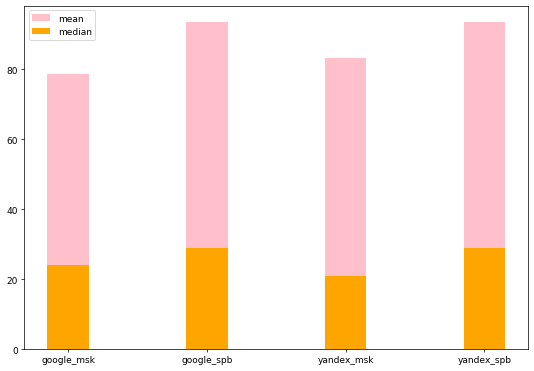

In [23]:
plt.figure(figsize=(10, 7), dpi=65)
plt.bar(what_in, mean, color = 'pink',  width=0.3, label='mean')
plt.bar(what_in, median, color = 'orange', width=0.3, label='median')
plt.legend(loc='upper left')

In [24]:
def one_word_percent(df):
    return len(df[df['count'] == 1])/len(df)

In [25]:
one_word_per_df = []
one_word_per_df.append(one_word_percent(google_msk_count_words_df))
one_word_per_df.append(one_word_percent(google_spb_count_words_df))
one_word_per_df.append(one_word_percent(yandex_msk_count_words_df))
one_word_per_df.append(one_word_percent(yandex_spb_count_words_df))

Text(0.5, 1.0, 'Процент слов встречающихся всего 1 раз')

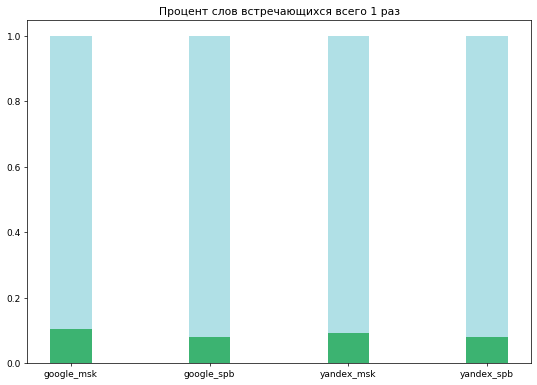

In [26]:
plt.figure(figsize=(10, 7), dpi=65)
plt.bar(what_in, 1, color = '#B0E0E6',  width=0.3)
plt.bar(what_in, one_word_per_df, color = '#3CB371',  width=0.3)
plt.title('Процент слов встречающихся всего 1 раз')

In [27]:
def bad_words_1(count_word):
    bad_words_1 = count_word[count_word['count'] == 1]['word'].values
    for i in bad_words_1:
        count_word = count_word[count_word['word'] != i]
    return count_word, bad_words_1

In [28]:
# удаляю те слова которые встречаются 1 раз
google_msk_count_words_df, bad_words_1_g_m = bad_words_1(google_msk_count_words_df)
google_spb_count_words_df, bad_words_1_g_s = bad_words_1(google_spb_count_words_df)
yandex_msk_count_words_df, bad_words_1_ya_m = bad_words_1(yandex_msk_count_words_df)
yandex_spb_count_words_df, bad_words_1_ya_s = bad_words_1(yandex_spb_count_words_df)

In [29]:
#все плохие слова теперь в одной куче, понадобится далее
bad_g_m = list(bad_words_1_g_m) +badwords_g_m
bad_g_s = list(bad_words_1_g_s) +badwords_g_s
bad_ya_m = list(bad_words_1_ya_m) +badwords_ya_m
bad_ya_s = list(bad_words_1_ya_s) +badwords_ya_s

In [30]:
def main_df_withount_bad_words(df):
    df.drop(badwords, axis = 1, inplace=True)
    df.drop(bad_words_1, axis = 1, inplace=True)
    return df

In [31]:
def top_word(df):
    return df['word'][df['count'] == df['count'].max()].values[0]

In [32]:
top_1_word = []
top_1_word.append(top_word(google_msk_count_words_df))
top_1_word.append(top_word(google_spb_count_words_df))
top_1_word.append(top_word(yandex_msk_count_words_df))
top_1_word.append(top_word(yandex_spb_count_words_df))
top_1_word_df = pd.DataFrame()
top_1_word_df['what_in'] = what_in
top_1_word_df['top_1'] = top_1_word

In [33]:
#самые часто встречающиеся слова в файле
top_1_word_df

,what_in,top_1
0,google_msk,рубль
1,google_spb,финансовый
2,yandex_msk,услуга
3,yandex_spb,финансовый


In [34]:
def top_10_word(df):
    dd = df[-10:].sort_values(by = 'count', ascending = False).reset_index()
    return dd['word']

In [35]:
top_10_g_m = top_10_word(google_msk_count_words_df)
top_10_g_s = top_10_word(google_spb_count_words_df)
top_10_ya_m = top_10_word(yandex_msk_count_words_df)
top_10_ya_s = top_10_word(yandex_spb_count_words_df)

In [36]:
#top 10 words in google_msk
top_10_g_m

0         рубль
1         карта
2          день
3        кредит
4        онлайн
5      документ
6    бесплатный
7      комиссия
8        ставка
9          счёт
Name: word, dtype: object

In [37]:
#top 10 words in google_spb
top_10_g_s

0      финансовый
1          услуга
2       оказывать
3           карта
4          ставка
5        документ
6            срок
7            счёт
8      бесплатный
9    обслуживание
Name: word, dtype: object

In [38]:
#top 10 words in yandex_msk
top_10_ya_m

0          услуга
1       оказывать
2           карта
3            счёт
4            срок
5        документ
6    обслуживание
7      бесплатный
8           рубль
9          ставка
Name: word, dtype: object

In [39]:
#top 10 words in yandex_spb
top_10_ya_s

0      финансовый
1          услуга
2       оказывать
3           карта
4          ставка
5        документ
6            срок
7            счёт
8      бесплатный
9    обслуживание
Name: word, dtype: object

In [40]:
def graf_frequency():
    ax_0.set_title("Frequency google_msk", fontsize=12)    
    ax_1.set_title("Frequency google_spb", fontsize=12)
    ax_2.set_title("Frequency yandex_msk", fontsize=12)
    ax_3.set_title("Frequency yandex_spb", fontsize=12)

In [41]:
def text_gr():
    plt.ylabel("Частота встречаний слов") 
    plt.xlabel("Количество слов(сколько раз оно встретилось в тексте)")

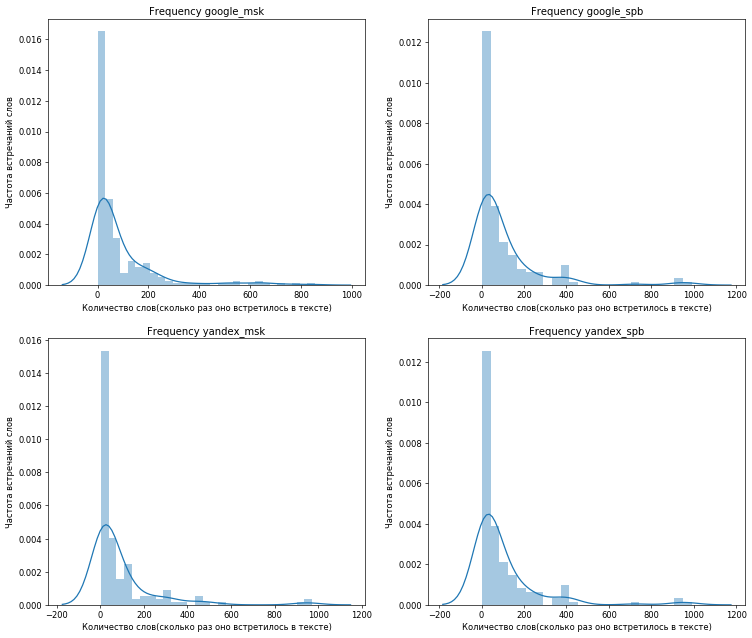

In [42]:
gridsize = (3, 2)
fig = plt.figure(figsize=(15, 20), dpi=60)

ax_0 = plt.subplot2grid(gridsize, (0, 0))
sns.distplot(google_msk_count_words_df['count'])
text_gr()
ax_1 = plt.subplot2grid(gridsize, (0, 1))
sns.distplot(google_spb_count_words_df['count'])
text_gr()
ax_2 = plt.subplot2grid(gridsize, (1, 0))
sns.distplot(yandex_msk_count_words_df['count'])
text_gr()
ax_3 = plt.subplot2grid(gridsize, (1, 1))
sns.distplot(yandex_spb_count_words_df['count'])
text_gr()
graf_frequency()

In [43]:
def main_df_withount_bad_words(df,badwords, bad_words_1):
    df.drop(badwords, axis = 1, inplace=True)
    df.drop(bad_words_1, axis = 1, inplace=True)
    return df

In [45]:
google_msk = main_df_withount_bad_words(google_msk,badwords_g_m ,bad_words_1_g_m)
google_spb = main_df_withount_bad_words(google_spb,badwords_g_s ,bad_words_1_g_s)
yandex_msk = main_df_withount_bad_words(yandex_msk,badwords_ya_m ,bad_words_1_ya_m)
yandex_spb = main_df_withount_bad_words(yandex_spb,badwords_ya_s ,bad_words_1_ya_s)

# ML
### ML: normalize + TSNE

In [46]:
google_msk_all = pd.concat([google_msk_extended, google_msk], axis = 1)
google_spb_all = pd.concat([google_spb_extended, google_spb], axis = 1)
yandex_msk_all = pd.concat([yandex_msk_extended, yandex_msk], axis = 1)
yandex_spb_all = pd.concat([yandex_spb_extended, yandex_spb], axis = 1)

In [47]:
def nomalize_fun(df, colum):
    df[colum] = (df[colum] - df[colum].min())/(df[colum].max() - df[colum].min())

In [48]:
def normalize_df(df):
    nomalize_fun(df, 'Volume')
    nomalize_fun(df, 'CPC')
    nomalize_fun(df, 'TraffShare %')
    nomalize_fun(df, 'KeyComp')
    return df

In [49]:
google_msk_all = normalize_df(google_msk_all)
google_spb_all = normalize_df(google_spb_all)
yandex_msk_all = normalize_df(yandex_msk_all)
yandex_spb_all = normalize_df(yandex_spb_all)

На данном этапе стоит выбор делать прогноз только на словах, разложенных на CountVectorizer() или на словах+характеристики('Volume', 'CPC', 'TraffShare %','KeyComp') и метрику, по которой нужно выбрать какой именно вариант оставлять.  
Хорошей метрикой оценивания кластеризации, когда нет исходного разбиения на кластеры является силуэт(sklearn.metrics.silhouette_score). Он принимает значения от -1 до 1, при этом чем лучше разбиение, тем ближе к 1 он должен быть.  
Лучше получились результаты на Kmeans, поэтому смотрим на silhouette_score именно на нем(вывод сделан после прогонки Kmeans и DBSCAN, который ниже).  
Сам cилуэт меряем Kmeans на google_msk, но тенденция к тому, что на Kmeans он выше, чем на DBSCAN прослеживается и на других df.
* В ячейке ниже без комментариев вариант с только словами, его silhouette_score = 0.36535406348348975
* В комментариях вариант слова+характеристики, его silhouette_score = 0.3646633000532693
Соответственно оставляем вариант с прогнозом только на словах, разложенных на CountVectorizer() 


In [51]:
google_msk_tsne = TSNE(random_state=42).fit_transform(google_msk)
google_spb_tsne = TSNE(random_state=42).fit_transform(google_spb)
yandex_msk_tsne = TSNE(random_state=42).fit_transform(yandex_msk)
yandex_spb_tsne = TSNE(random_state=42).fit_transform(yandex_spb)


#google_msk_tsne = TSNE(random_state=42).fit_transform(google_msk_all)
#google_msk = google_msk_all

In [52]:
def graf():
    ax0.set_title('google_msk', fontsize=12);
    ax0.scatter(google_msk_tsne[:, 0], google_msk_tsne[:, 1], s=0001.)
    ax0.set_aspect('equal', 'datalim')
    
    ax1.set_title('google_spb', fontsize=12);
    ax1.scatter(google_spb_tsne[:, 0], google_spb_tsne[:, 1], s=0001.)
    ax1.set_aspect('equal', 'datalim')
    
    ax2.set_title('yandex_msk', fontsize=12);
    ax2.scatter(yandex_msk_tsne[:, 0], yandex_msk_tsne[:, 1], s=0001.)
    ax2.set_aspect('equal', 'datalim')
    
    ax3.set_title('yandex_spb', fontsize=12);
    ax3.scatter(yandex_spb_tsne[:, 0], yandex_spb_tsne[:, 1], s=0001.)
    ax3.set_aspect('equal', 'datalim')

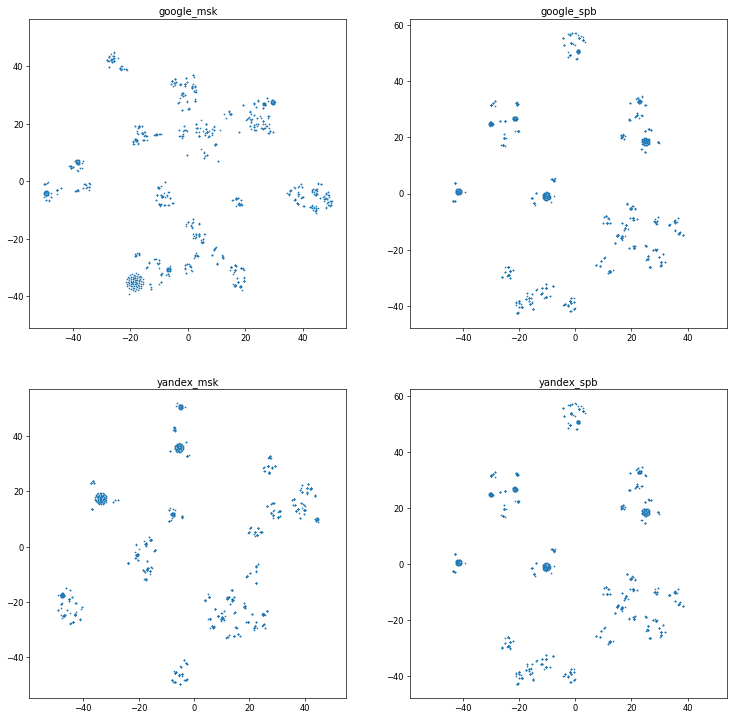

In [53]:
gridsize = (2, 2)
fig = plt.figure(figsize=(15, 15), dpi=60)
ax0 = plt.subplot2grid(gridsize, (0, 0))
ax1 = plt.subplot2grid(gridsize, (0, 1))
ax2 = plt.subplot2grid(gridsize, (1, 0))
ax3 = plt.subplot2grid(gridsize, (1, 1))
graf()

По графикам видно, что области, похожие на примерное разбиение кластеров, получились выпуклыми, значит можно использовать DBSCAN и KMeans, нет необходимость использовать спектральную кластеризаю, которая работает долго.
Особенность работы DBSCAN, что он хорошо предсказывает плотные выпуклые кластеры и не так хорошо предсказывает "разряженные" кластеры, которых тут достаточно много.

## ML: DBSCAN

Убеждаемся, что DBSCAN дает результат хуже чем Kmeans(вывод сделан после прогонки Kmeans, который ниже)

In [54]:
sil_score_d = []
sil_e = []
for e in range(1, 50, 5):
    dbsc = DBSCAN(eps = e/100, min_samples=20).fit_predict(google_msk)
    sil_e.append(e/100)
    sil_score_d.append(silhouette_score(google_msk, dbsc))

In [55]:
def dbsc_best(df):
    sil_score_d = []
    sil_e = []
    for e in range(1, 500, 10):
        dbsc = DBSCAN(eps = e/100, min_samples=20).fit_predict(df)
        sil_e.append(e/100)
        try:
            sil_score_d.append(silhouette_score(df, dbsc))
        except:
            sil_score_d.append(0)
        
    sil_dbscn_df =  pd.DataFrame()
    sil_dbscn_df['e']=sil_e
    sil_dbscn_df['sil_score']=sil_score_d
    epsil = sil_dbscn_df[sil_dbscn_df['sil_score'] == sil_dbscn_df['sil_score'].max()]['e'].values[0]
    print('max silhouette_score:', sil_dbscn_df['sil_score'][sil_dbscn_df['e'] == epsil].values[0])
    print('eps:', epsil)
    return epsil

In [56]:
epsil_g_m = dbsc_best(google_msk)
epsil_g_s = dbsc_best(google_spb)
epsil_ya_m = dbsc_best(yandex_msk)
epsil_ya_s = dbsc_best(yandex_spb)

max silhouette_score: 0.30968706366709087
eps: 3.61
max silhouette_score: 0.3110810157857825
eps: 3.41
max silhouette_score: 0.2864885927970828
eps: 3.21
max silhouette_score: 0.3110810157857825
eps: 3.41


In [57]:
google_msk_dbscan = DBSCAN(eps = epsil_g_m, min_samples=20).fit_predict(google_msk)
google_spb_dbscan = DBSCAN(eps = epsil_g_s, min_samples=20).fit_predict(google_spb)
yandex_msk_dbscan = DBSCAN(eps = epsil_ya_m, min_samples=20).fit_predict(yandex_msk)
yandex_spb_dbscan = DBSCAN(eps = epsil_ya_s, min_samples=20).fit_predict(yandex_spb)

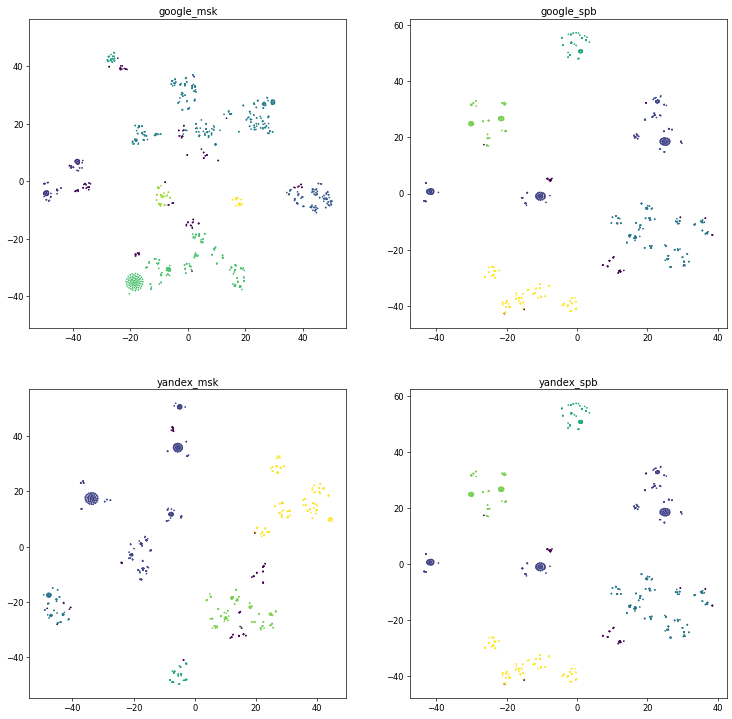

In [58]:
fig = plt.figure(figsize=(15, 15), dpi=60)

ax_0 = plt.subplot2grid(gridsize, (0, 0))
ax_0.set_title('google_msk', fontsize=12)
ax_0.scatter(google_msk_tsne[:, 0], google_msk_tsne[:, 1], c = google_msk_dbscan, s=0001.)
ax_0.set_aspect('equal', 'datalim')

ax_1 = plt.subplot2grid(gridsize, (0, 1))
ax_1.set_title('google_spb', fontsize=12)
ax_1.scatter(google_spb_tsne[:, 0], google_spb_tsne[:, 1], c = google_spb_dbscan, s=0001.)

ax_2 = plt.subplot2grid(gridsize, (1, 0))
ax_2.set_title('yandex_msk', fontsize=12)
ax_2.scatter(yandex_msk_tsne[:, 0], yandex_msk_tsne[:, 1], c = yandex_msk_dbscan, s=0001.)

ax_3 = plt.subplot2grid(gridsize, (1, 1))
ax_3.set_title('yandex_spb', fontsize=12)
ax_3.scatter(yandex_spb_tsne[:, 0], yandex_spb_tsne[:, 1], c = yandex_spb_dbscan, s=0001.)

## ML: Kmeans++

In [59]:
def kmeans_best(df, col):
    inertia = []
    sil_score = []
    sil_k = []
    for k in range(2, 20):
        kmeans = KMeans(n_clusters=k, random_state=1).fit(df)
        inertia.append(np.sqrt(kmeans.inertia_))
        kmeans_pr = KMeans(n_clusters=k, random_state=1).fit_predict(df)
        sil_k.append(k)
        sil_score.append(silhouette_score(df, kmeans_pr))

    plt.plot(range(2, 20), inertia, marker='s', color = col);
    plt.xlabel('$k$')
    plt.ylabel('$J(C_k)$');

    sil_kmean_df =  pd.DataFrame()
    sil_kmean_df['k']=sil_k
    sil_kmean_df['sil_score']=sil_score
    k_kmeans = sil_kmean_df[sil_kmean_df['sil_score'] == sil_kmean_df['sil_score'].max()]['k'].values[0]
    print('max silhouette_score:', sil_kmean_df['sil_score'][sil_kmean_df['k'] == k_kmeans].values[0])
    print('k:', k_kmeans)
    return k_kmeans

max silhouette_score: 0.36535406348348975
k: 11
max silhouette_score: 0.4065479193719201
k: 18
max silhouette_score: 0.38447947593752013
k: 19
max silhouette_score: 0.4065479193719201
k: 18


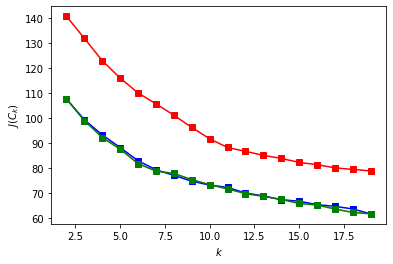

In [60]:
#число кластеров выбираем таким, когда падение становится "не таким уж быстрым" ---> 11.. 12(визуальная проверка по теории)
#в дейситвительности смотрим на силуэт
#нормально, что не видно розовой линии - она зетерлась зеленой, так как датафреймы гугл спб и яндекс спб одинаковые
kmeans_g_m = kmeans_best(google_msk, 'red')
kmeans_g_s = kmeans_best(google_spb, 'pink')
kmeans_ya_m = kmeans_best(yandex_msk, 'blue')
kmeans_ya_s = kmeans_best(yandex_spb, 'green')

In [61]:
google_msk_kmeans = KMeans(n_clusters = kmeans_g_m, init = 'k-means++', random_state=1).fit_predict(google_msk)
google_spb_kmeans = KMeans(n_clusters = kmeans_g_s, init = 'k-means++', random_state=1).fit_predict(google_spb)
yandex_msk_kmeans = KMeans(n_clusters = kmeans_ya_m, init = 'k-means++', random_state=1).fit_predict(yandex_msk)
yandex_spb_kmeans = KMeans(n_clusters = kmeans_ya_s, init = 'k-means++', random_state=1).fit_predict(yandex_spb)

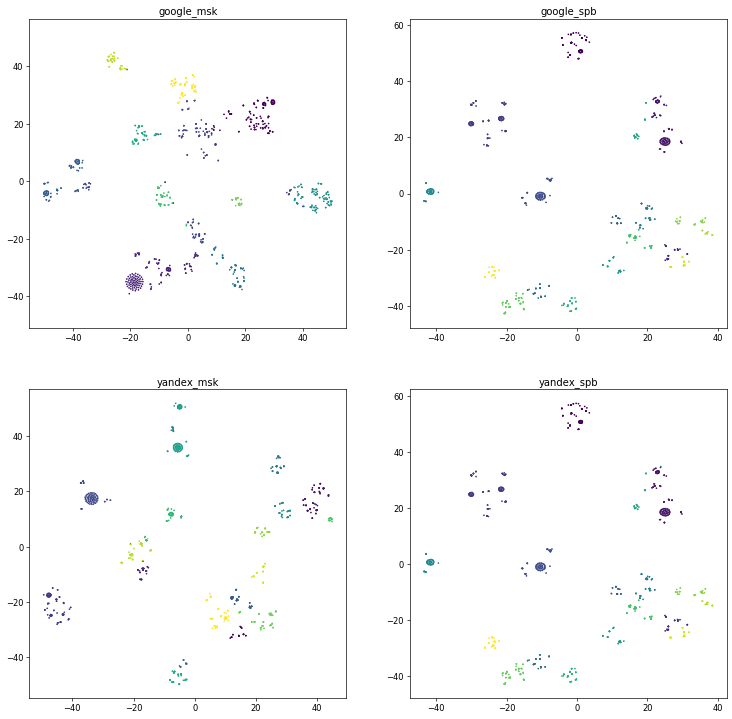

In [62]:
fig = plt.figure(figsize=(15, 15), dpi=60)

ax_0 = plt.subplot2grid(gridsize, (0, 0))
ax_0.set_title('google_msk', fontsize=12)
ax_0.scatter(google_msk_tsne[:, 0], google_msk_tsne[:, 1], c = google_msk_kmeans, s=0001.)
ax_0.set_aspect('equal', 'datalim')

ax_1 = plt.subplot2grid(gridsize, (0, 1))
ax_1.set_title('google_spb', fontsize=12)
ax_1.scatter(google_spb_tsne[:, 0], google_spb_tsne[:, 1], c = google_spb_kmeans, s=0001.)

ax_2 = plt.subplot2grid(gridsize, (1, 0))
ax_2.set_title('yandex_msk', fontsize=12)
ax_2.scatter(yandex_msk_tsne[:, 0], yandex_msk_tsne[:, 1], c = yandex_msk_kmeans, s=0001.)

ax_3 = plt.subplot2grid(gridsize, (1, 1))
ax_3.set_title('yandex_spb', fontsize=12)
ax_3.scatter(yandex_spb_tsne[:, 0], yandex_spb_tsne[:, 1], c = yandex_spb_kmeans, s=0001.)

# Main word in clust

In [63]:
def del_bad_words(x):
    for i in bad_g_m:
        x = x.replace(i, '')
    return x

In [64]:
sentences_g_m_not_bw = pd.Series(sentences_g_m).apply(lambda x: del_bad_words(x))
sentences_g_s_not_bw = pd.Series(sentences_g_s).apply(lambda x: del_bad_words(x))
sentences_ya_m_not_bw = pd.Series(sentences_ya_m).apply(lambda x: del_bad_words(x))
sentences_ya_s_not_bw = pd.Series(sentences_ya_s).apply(lambda x: del_bad_words(x))

In [65]:
def clust_sent(df, df_kmeans, sentences):
    res_g_m = pd.DataFrame()
    res_g_m['labels'] = df_kmeans
    res_g_m['sets'] = sentences
    res_counts_g_m = pd.concat([res_g_m, df], axis = 1)
    return res_counts_g_m

In [66]:
res_g_m = clust_sent(google_msk, google_msk_kmeans, sentences_g_m_not_bw)
res_g_s = clust_sent(google_spb, google_spb_kmeans, sentences_g_s_not_bw)
res_ya_m = clust_sent(yandex_msk, yandex_msk_kmeans, sentences_ya_m_not_bw)
res_ya_s = clust_sent(yandex_spb, yandex_spb_kmeans, sentences_ya_s_not_bw)

In [67]:
res_label_sets_g_m = res_g_m[['labels', 'sets']]
res_label_sets_g_s = res_g_s[['labels', 'sets']]
res_label_sets_ya_m = res_ya_m[['labels', 'sets']]
res_label_sets_ya_s = res_ya_s[['labels', 'sets']]

In [68]:
res_label_sets_g_m = res_g_m
res_g_s = clust_sent(google_spb, google_spb_kmeans, sentences_g_s_not_bw)
res_ya_m = clust_sent(yandex_msk, yandex_msk_kmeans, sentences_ya_m_not_bw)
res_ya_s = clust_sent(yandex_spb, yandex_spb_kmeans, sentences_ya_s_not_bw)

In [69]:
def main_word_clust(k_kmeans,df):
    clast = [] 
    len_clast = []
    for i in range(k_kmeans):
        clast.append(list(reversed(list(df[df['labels'] == i].drop(['labels', 'sets'], axis = 1).sum(axis = 0).sort_values()[-10: ].index))))
        len_clast.append(len(df[df['labels'] == i]))
    return len_clast, clast

In [70]:
def clust_info(k_kmeans,df):
    len_clast, clast = main_word_clust(k_kmeans,df)
    clast_info = pd.DataFrame([i for i in range(len(len_clast))])
    clast_info.columns = ['nom_clust']
    clast_info['len_clust'] = len_clast
    clast_info['top_words'] = clast
    return clast_info

In [71]:
clust_info_g_m = clust_info(kmeans_g_m, res_g_m)
clust_info_g_s = clust_info(kmeans_g_s, res_g_s)
clust_info_ya_m = clust_info(kmeans_ya_m, res_ya_m)
clust_info_ya_s = clust_info(kmeans_ya_s, res_ya_s)

In [72]:
print('Рузультаты кластеризации google_msk')
clust_info_g_m

Рузультаты кластеризации google_msk


,nom_clust,len_clust,top_words
0,0,131,"[поручитель, ставка, рубль, кредит, бесплатный..."
1,1,164,"[онлайн, помощь, счёт, райффайзенбанк, докумен..."
2,2,163,"[кредит, ставка, рубль, документ, счёт, карта,..."
3,3,97,"[покупка, карта, обслуживание, рубль, кэшбэк, ..."
4,4,83,"[помощь, онлайн, рубль, кредит, любой, гаранти..."
5,5,105,"[день, карта, бесплатный, комиссия, наличный, ..."
6,6,61,"[день, документ, взнос, рубль, кредит, деньга,..."
7,7,54,"[счёт, накопительный, открыть, ставка, минимал..."
8,8,26,"[гарантия, банковский, выпуск, день, течение, ..."
9,9,45,"[вклад, открыть, ставка, получать, выгодный, з..."


In [73]:
print('Рузультаты кластеризации google_spb')
clust_info_g_s

Рузультаты кластеризации google_spb


,nom_clust,len_clust,top_words
0,0,90,"[день, наличный, комиссия, снимать, август, за..."
1,1,121,"[бесплатный, обслуживание, карта, весь, срок, ..."
2,2,36,"[кредит, ставка, документ, финансовый, рефинан..."
3,3,134,"[получать, вклад, доход, ежемесячный, ставка, ..."
4,4,85,"[рубль, карта, весь, заказать, сегодня, срок, ..."
5,5,25,"[залог, погашение, досрочный, ограничение, пор..."
6,6,47,"[счёт, пополнение, карта, комиссия, документ, ..."
7,7,57,"[рубль, цель, любой, документ, ставка, кредит,..."
8,8,54,"[карта, платить, течение, обслуживание, срок, ..."
9,9,33,"[ставка, счёт, накопительный, финансовый, услу..."


In [74]:
print('Рузультаты кластеризации yandex_msk')
clust_info_ya_m

Рузультаты кластеризации yandex_msk


,nom_clust,len_clust,top_words
0,0,25,"[кредит, авто, каско, услуга, взнос, ставка, о..."
1,1,91,"[счёт, минута, карта, подарок, документ, онлай..."
2,2,40,"[бесплатный, оформить, обслуживание, срок, вес..."
3,3,104,"[день, заказать, комиссия, наличный, снимать, ..."
4,4,88,"[карта, обслуживание, платить, срок, течение, ..."
5,5,52,"[год, документ, срок, услуга, ставка, кредит, ..."
6,6,14,"[доход, год, каждый, получать, рубль, процент,..."
7,7,48,"[счёт, посещение, документ, карта, отделение, ..."
8,8,14,"[рубль, карта, весь, заказать, сегодня, обслуж..."
9,9,45,"[счёт, комиссия, пополнение, карта, бесплатный..."


In [75]:
print('Рузультаты кластеризации yandex_spb')
clust_info_ya_s

Рузультаты кластеризации yandex_spb


,nom_clust,len_clust,top_words
0,0,90,"[день, наличный, комиссия, снимать, август, за..."
1,1,121,"[бесплатный, обслуживание, карта, весь, срок, ..."
2,2,36,"[кредит, ставка, документ, финансовый, рефинан..."
3,3,134,"[получать, вклад, доход, ежемесячный, ставка, ..."
4,4,85,"[рубль, карта, весь, заказать, сегодня, срок, ..."
5,5,25,"[залог, погашение, досрочный, ограничение, пор..."
6,6,47,"[счёт, пополнение, карта, комиссия, документ, ..."
7,7,57,"[рубль, цель, любой, документ, ставка, кредит,..."
8,8,54,"[карта, платить, течение, обслуживание, срок, ..."
9,9,33,"[ставка, счёт, накопительный, финансовый, услу..."


# Part 2

In [76]:
products = pd.DataFrame()
products['title'] = pd.Series(['вклад', 'ипотека', 'рачетно-кассовое обслуживание','кредитование малого бизнеса', 'потребительские кредиты','кредитные карты','дебетовые карты','прочее'])

In [77]:
products

,title
0,вклад
1,ипотека
2,рачетно-кассовое обслуживание
3,кредитование малого бизнеса
4,потребительские кредиты
5,кредитные карты
6,дебетовые карты
7,прочее


In [78]:
prod_list_g_m = ['потребительские кредиты','рачетно-кассовое обслуживание', 'прочее', 'дебетовые карты','рачетно-кассовое обслуживание', 'кредитные карты', 'кредит авто', 'накопительный счёт', 'банковский гарантия','открыть вклад', 'рефинансировать кредит']

In [79]:
prod_list_g_m_number = [4,2, 3, 6, 2, 5, 1, 0,0, 7, 0]

In [80]:
clust_info_g_m['nom_cl_prod'] = prod_list_g_m
clust_info_g_m['nom_cl_prod_nomb'] = prod_list_g_m_number
clust_info_g_m

,nom_clust,len_clust,top_words,nom_cl_prod,nom_cl_prod_nomb
0,0,131,"[поручитель, ставка, рубль, кредит, бесплатный...",потребительские кредиты,4
1,1,164,"[онлайн, помощь, счёт, райффайзенбанк, докумен...",рачетно-кассовое обслуживание,2
2,2,163,"[кредит, ставка, рубль, документ, счёт, карта,...",прочее,3
3,3,97,"[покупка, карта, обслуживание, рубль, кэшбэк, ...",дебетовые карты,6
4,4,83,"[помощь, онлайн, рубль, кредит, любой, гаранти...",рачетно-кассовое обслуживание,2
5,5,105,"[день, карта, бесплатный, комиссия, наличный, ...",кредитные карты,5
6,6,61,"[день, документ, взнос, рубль, кредит, деньга,...",кредит авто,1
7,7,54,"[счёт, накопительный, открыть, ставка, минимал...",накопительный счёт,0
8,8,26,"[гарантия, банковский, выпуск, день, течение, ...",банковский гарантия,0
9,9,45,"[вклад, открыть, ставка, получать, выгодный, з...",открыть вклад,7


Размечаем данные: из тех кластеров, что вышли удачными, берем значения, другие подгоняем

In [81]:
#размечаем данные: 
label_4 = res_label_sets_g_m[res_label_sets_g_m['labels'] == 0].index[0:14]
label_2 = res_label_sets_g_m[res_label_sets_g_m['labels'] == 1].index[0:14]
label_5 = res_label_sets_g_m[res_label_sets_g_m['labels'] == 5].index[0:14]
label_6 = res_label_sets_g_m[res_label_sets_g_m['labels'] == 3].index[0:14]
label_0 = res_label_sets_g_m[res_label_sets_g_m['labels'] == 9].index[0:14]
label_3 = res_label_sets_g_m[res_label_sets_g_m['sets'].apply(lambda x: ('кредит' in x) and ('бизнес' in x) and ('рко' not in x.lower()))].index[0:14]
label_1 = res_label_sets_g_m[res_label_sets_g_m['sets'].apply(lambda x: 'ипотека' in x)].index[0:14]
label_7 = res_label_sets_g_m[(res_label_sets_g_m['labels'] == 2) & (res_label_sets_g_m['sets'].apply(lambda x:('вклад' not in x.lower()) and ('карта' not in x.lower()) and ('рко' not in x.lower()) and ('кредит' not in x.lower()) and ('ипотека' not in x.lower())))].index[0:14]

In [82]:
to_clas = pd.DataFrame(res_label_sets_g_m['sets'])
label = []

for i in range(len(to_clas)):
    if i in label_0:
        label.append(0)
    elif i in label_1:
        label.append(1)
    elif i in label_2:
        label.append(2)
    elif i in label_3:
        label.append(3)
    elif i in label_4:
        label.append(4)
    elif i in label_5:
        label.append(5)
    elif i in label_6:
        label.append(6)
    elif i in label_7:
        label.append(7)
    else:
        label.append(-1)

to_clas['label']  = label   


In [83]:
to_clas_table_save = pd.concat([to_clas, google_msk], axis = 1)
to_clas_table = to_clas_table_save.drop('sets', axis = 1)

In [84]:
to_clas_table_train = to_clas_table[to_clas_table['label'] != -1]
to_clas_table_test = to_clas_table[to_clas_table['label'] == -1].drop('label', axis = 1)

In [85]:
X = to_clas_table_train.drop('label', axis = 1)
y = to_clas_table_train['label']

In [92]:
from sklearn.metrics import mean_absolute_error

In [3]:
xgb_cl = XGBClassifier()
svc_cl = svm.SVC(kernel='linear', C=1)
# scores_xgb = cross_val_score(xgb_cl, X, y, cv=6,scoring= mean_absolute_error )
# scores_svc = cross_val_score(svc_cl, X, y, cv=10)

In [87]:
scores_xgb

array([1.        , 0.95833333, 0.875     , 1.        , 0.9375    ,
       1.        ])

In [88]:
#переобучение
scores_svc

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [89]:
xgb = XGBClassifier().fit(X, y)
res = xgb.predict(to_clas_table_test)

In [4]:
test_res = to_clas_table_save[to_clas_table_save['label'] == -1]
test_res['res_class'] = res
test_res[['sets', 'res_class']].style.set_properties(subset=['sets'], **{'width': '600px'})

0	вклад  
1	ипотека  
2	рачетно-кассовое обслуживание  
3	кредитование малого бизнеса  
4	потребительские кредиты  
5	кредитные карты  
6	дебетовые карты  
7	прочее  